In [111]:
import numpy as np
import pandas as pd
import seaborn_image as isns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import sys
import math
import random

from skimage.io import imread
from skimage.io import imshow
from skimage.transform import resize


References:
https://neuraldatascience.io/8-mri/read_viz.html
https://www.kaggle.com/datasets/tourist55/alzheimers-dataset-4-class-of-images


In [51]:
input_path = 'Alzheimer_s Dataset/'
dataset1 = 'Dataset1/train'
dataset2 = 'Dataset2/'

categories = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented'] #our labels manually set
#or os.listdir(input_path)

#List containing images in its np.array
images = []
images2 = []

#The hard labels of each picture in order
labels = []
labels2 = []

#Number of images of each category
numberofimages = []
numberofimages2 = []

#similar to rmarkdown to get file directories
for category in categories:
    firstPath = os.path.join(input_path, dataset1, category)
    secondPath = os.path.join(input_path, dataset2, category)

    numberofimages.append(len(os.listdir(firstPath)))
    numberofimages2.append(len(os.listdir(secondPath)))

    for file in os.listdir(firstPath):
        image_paths = os.path.join(firstPath, file) #image in this case refers to title of the image
        image = imread(image_paths, as_gray=True) #reads an image, imread - image + read and grayscales all images
        images.append(image)
        labels.append(category)

    for file in os.listdir(secondPath):
        image_paths2 = os.path.join(secondPath, file) #image in this case refers to title of the image
        image2 = imread(image_paths2, as_gray=True) #reads an image, imread - image + read and grayscales all images
        images2.append(image2)
        labels2.append(category)


In [54]:
#number of images
print(numberofimages)
print(numberofimages2)

[2560, 1792, 717, 52]
[3200, 2240, 896, 64]


In [84]:
#Splitting it to respective list for DATASET1 so we can do analysis
nonDemented = images[1:2561]
veryMildDemented = images[2561:4353]
MildDemented = images[4353:5070]
ModerateDemented = images[5069:5122]

lst = [nonDemented, veryMildDemented, MildDemented, ModerateDemented]

In [53]:
#dimensions of an image
print(nonDemented[1].shape)
print(images2[1].shape)
print(resize(nonDemented[1], (128, 128).shape)

#different dimensions so we need to preprocess it to the same size

(208, 176)
(128, 128)


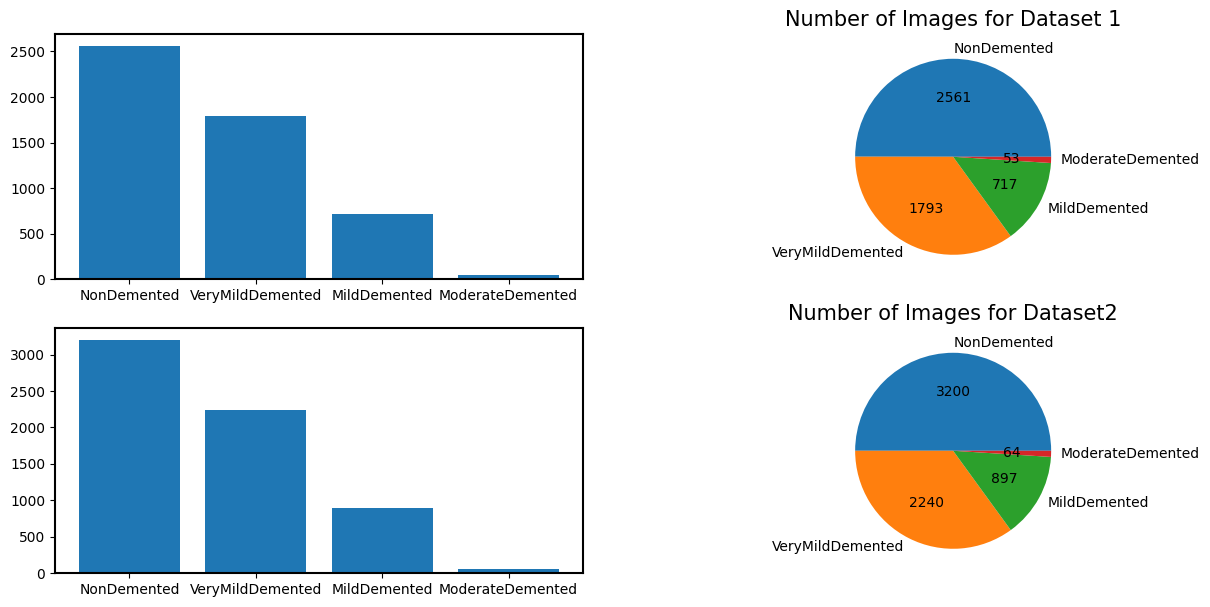

In [71]:
#Plotting number of images for visual representation
fig, ax = plt.subplots(2,2 , figsize = (15,7))
ax[0,0].bar(categories, numberofimages)
ax[0,1].pie(numberofimages, labels= categories, autopct = lambda x: math.ceil(x/100 * sum(numberofimages)))
ax[0,1].set_title('Number of Images for Dataset 1')

ax[1,0].bar(categories, numberofimages2)
ax[1,1].pie(numberofimages2, labels = categories, autopct = lambda x: math.ceil(x/100 * sum(numberofimages2)))
ax[1,1].set_title('Number of Images for Dataset2')

plt.show()

#Shows some need for data augmentation since insufficient samples for ModerateDemented.
#We can do rotations or cropping into image for data augmentation.

In [67]:
zipped = zip(numberofimages, numberofimages2)
totalNum = [sum(i) for i in zipped]
totalNum

[5760, 4032, 1613, 116]

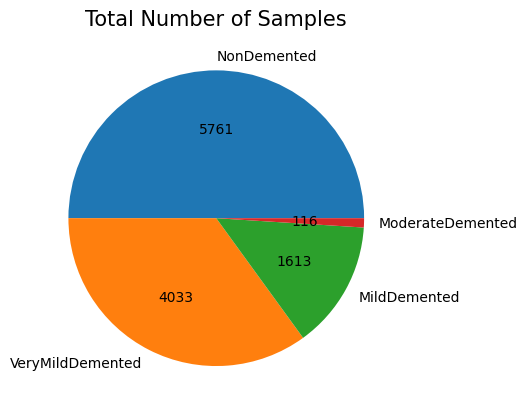

In [78]:
#Overall pie chart
plt.pie(totalNum, labels = categories, autopct = lambda x: math.ceil(x/100 * sum(totalNum)))
plt.title('Total Number of Samples')
plt.show()

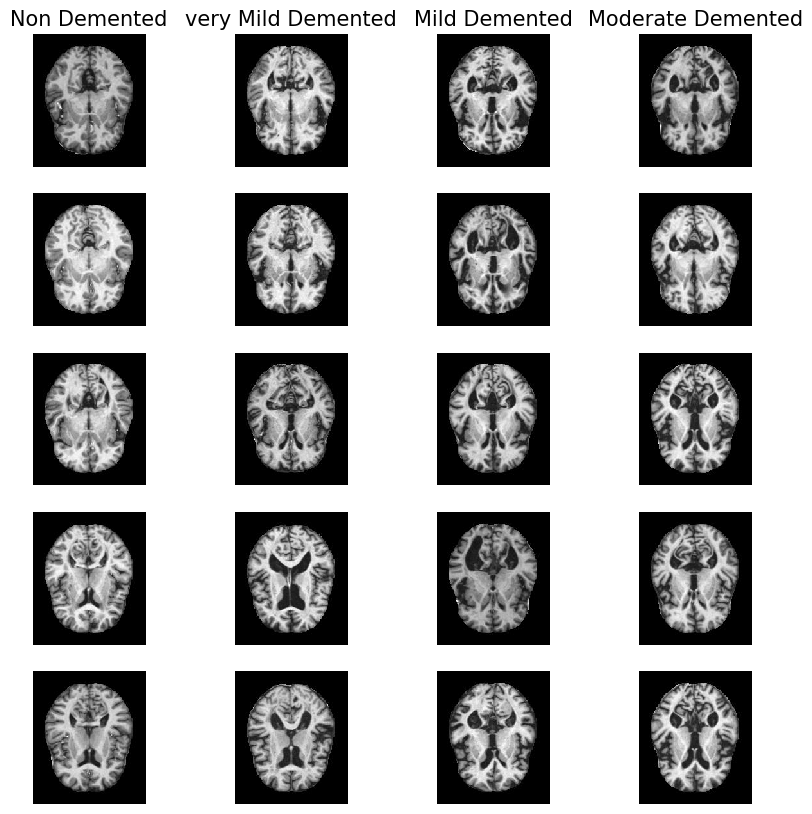

In [10]:
#First 4 pictures to roughly show how each MRI Scan for each category looks like
fig,axes = plt.subplots(5,4, figsize = (10,10))

for i in range(len(lst)):
    for j in range(5):
        img = lst[i][j]
        axes[j,i].imshow(img, cmap = 'gray')
        axes[j,i].axis('off') #turn off axis for each subplot
axes[0,0].set_title('Non Demented', fontsize = 15)
axes[0,1].set_title('very Mild Demented', fontsize = 15)
axes[0,2].set_title('Mild Demented', fontsize = 15)
axes[0,3].set_title('Moderate Demented', fontsize = 15)
plt.show()

In [85]:
#Flatten 30 images and join them together then plot a histogram to get the rough distribution of the pixels rgb;
allFlattened = []
for i in range(len(lst)):
    flat = []
    for j in range(30):
        flat.extend(lst[i][j].flatten()) #extend function instead of append to add raw values rather than a list
    allFlattened.append(flat)


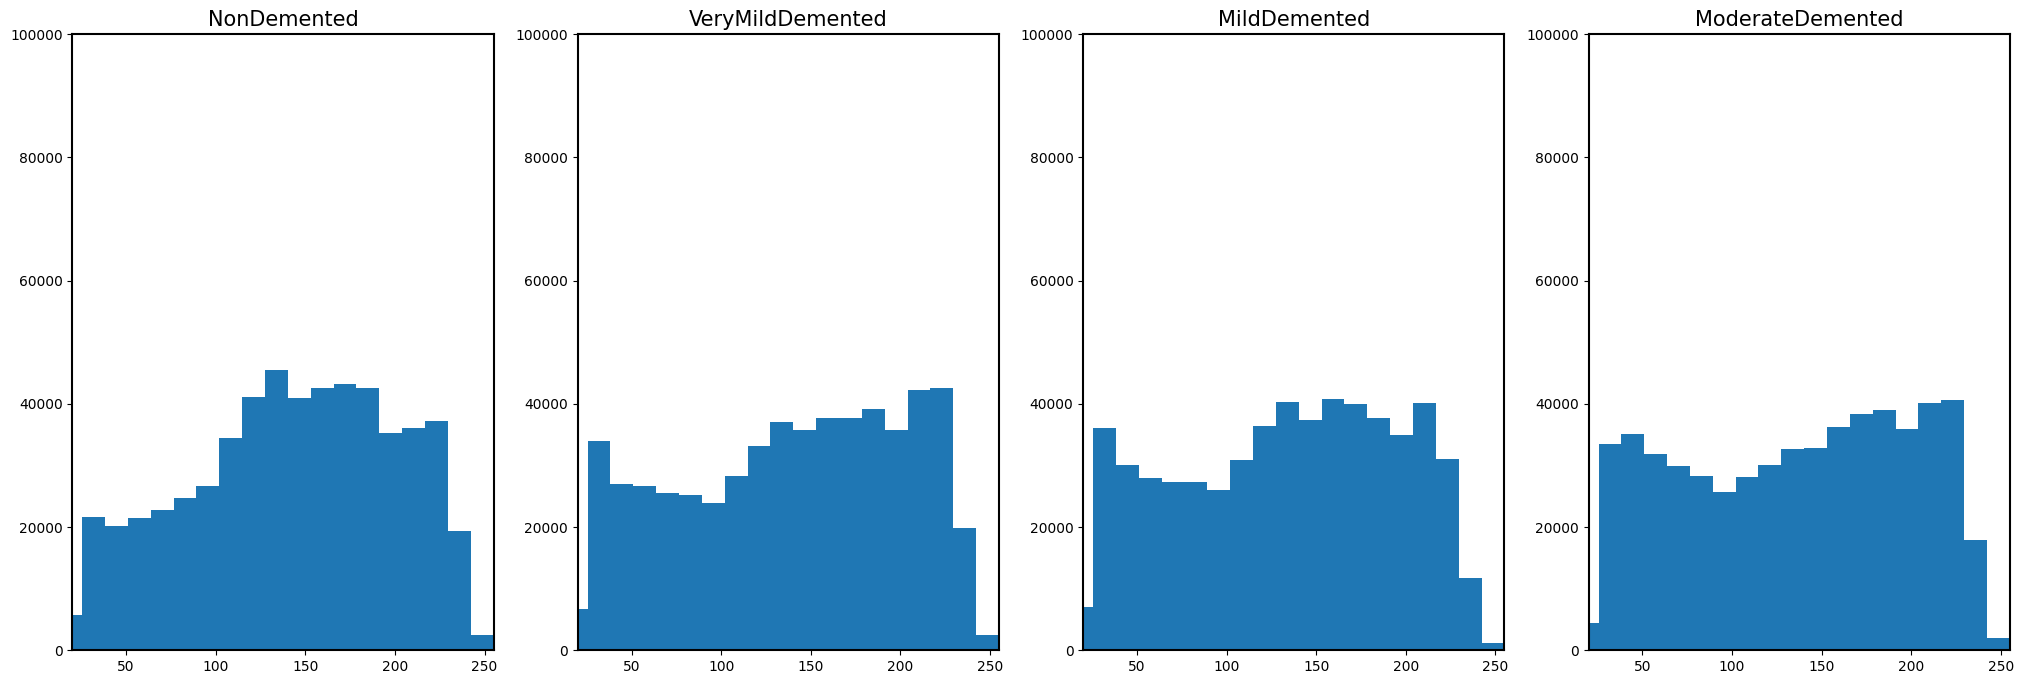

In [89]:
fig, axes = plt.subplots(1,4, figsize = (25,8))
for i in range(len(allFlattened)):
    axes[i].hist(allFlattened[i], bins = 20)
    axes[i].set_title(categories[i])
    axes[i].set_xlim([20,255])
    axes[i].set_ylim([0,100000])


In the region of pixel 20 to pixel 100, its noticable that the non demented people have significantly less black pixels
Can play around with the bin number but it shows almost the same r/s

But theres not very evident r/s between the pixels and the severity of dementia

Now convert it to binary image by setting pixel 50 to approximately 100 as the region as white and the rest as black and do an image visualization

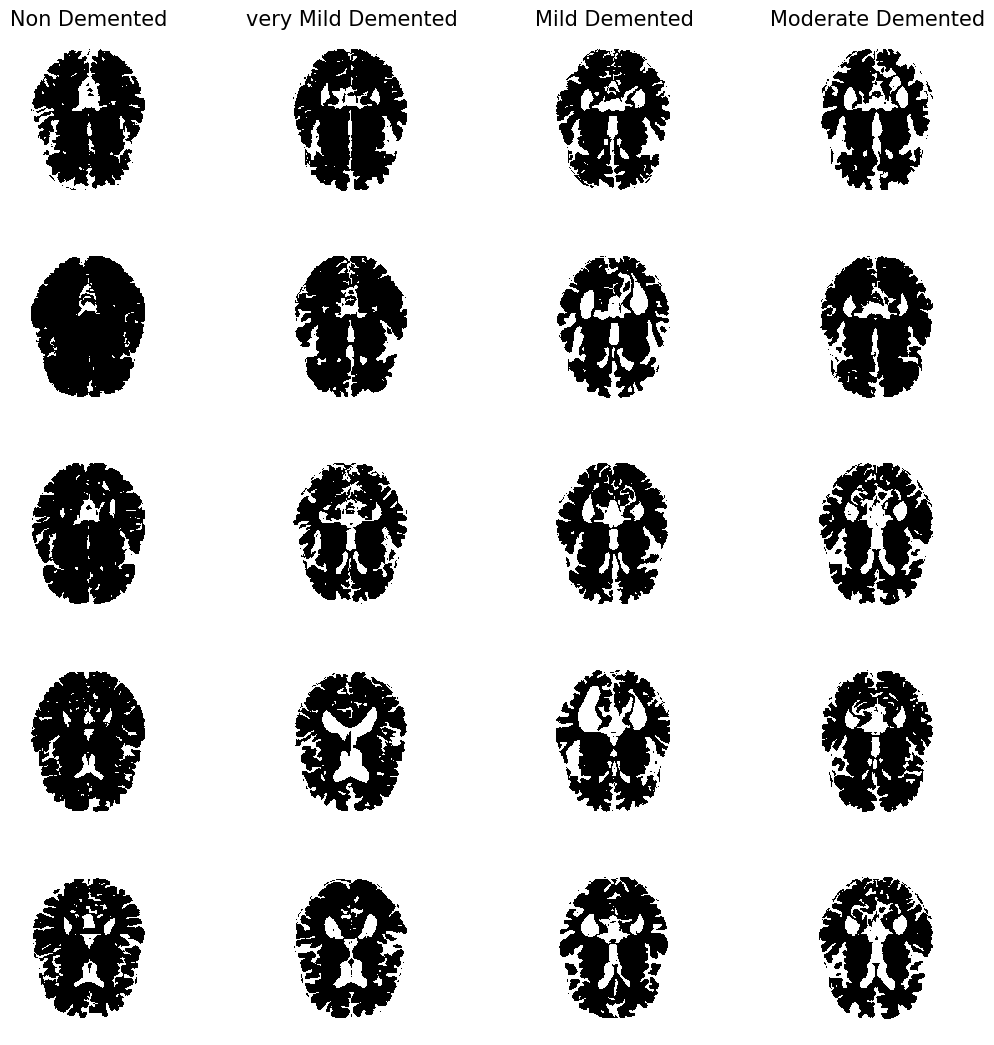

In [114]:
#Convert all pictures to binary to showcase degree of white are
fig,axes = plt.subplots(5,4, figsize = (13,13))

for i in range(len(lst)):
    for j in range(5):
        img = lst[i][j]
        #binary1 = np.where(img >= 50,1,0)
        binary2 = np.where(img <= 90,1,0)
        #newimg = binary1 + binary2
        axes[j,i].imshow(binary2, cmap = 'gray')
        axes[j,i].axis('off') #turn off axis for each subplot
axes[0,0].set_title('Non Demented', fontsize = 15)
axes[0,1].set_title('very Mild Demented', fontsize = 15)
axes[0,2].set_title('Mild Demented', fontsize = 15)
axes[0,3].set_title('Moderate Demented', fontsize = 15)
plt.show()

Appears that the middle region has increasing number of white pixels as well as the sides of the bottom

Seems to have greater atrophy of muscles as alzheimer progress increases

this coincides with the picture in the reference image, hippocamus area has increasing amounts of white pixels(the part that looks like an egg) + muscle walls or something become less thick
but also pretty difficult to differentiate between mild and moderate alzheimer



#reference to image
https://www.mdpi.com/1422-0067/22/4/2110







Things to do for preprocessing

1) Resize dataset1 and dataset2 such that they have the same dimension
2) Crop it as much as possible first with the whole head in place during resize like 
3) Augment images for moderately demented because too little data, some things to do is like flipping the images or like slightly rotating the pic by like 5 degree(dont 90 degree rotate because our data is already straight(?) idk how to say but just do a horizontal flip)


Things to do for data to maybe make learning easier
1) Dimension reductionality -- Identify most important region for getting high accuracy when we do ml test 
Possible regions of interest -- How big the white spaces are which show muscle atrophy
